# NL COVID 19 data exploration

- data from https://data.rivm.nl/covid-19/
- taken 14 Aug 2020

## Notes

- Given that daily reported numbers are in small quantities
(i.e. <100), changes represented in % changes
can be highly sensitive.
E.g. Changing from 1 to 5 is a 500% change.
- But % change is the only way to
compare change in qty across different slices
of data.
- So take those figures with a pinch of salt.
- That being said, we are looking for anomalies,
so a sufficiently large % change would signal
an abnormally large change.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import typing

plt.rcParams["figure.figsize"] = (20,15)
_FONTSIZE=20

# Initial data management
_DATADIR="../_data"
_DATA_CUMUL="COVID-19_aantallen_gemeente_cumulatief-2020-08-14.csv"
cumul = pd.read_csv(os.path.join(_DATADIR, _DATA_CUMUL), delimiter=";")
cumul["Date_of_report"] = pd.to_datetime(cumul["Date_of_report"]) # set dtype of "Date_of_report" to pd.DatetimeTZDtype
cumul["Date_of_report"] = cumul["Date_of_report"].dt.normalize() # get date portion of datetime only
cumul.sort_values(by="Date_of_report",ascending=True,inplace=True)

 # Get only cases from Amsterdam:
cumul_ams = cumul[cumul["Municipality_name"].isin(["Amsterdam"])]

# compare day on day increments/deltas
def get_daily_delta(df: pd.DataFrame, col: str) -> typing.List[int]:
    """
    Returns list containing day to day changes in reported cases
    """
    daily_delta_column = []
    reported = df[col]
    for i in range(0,len(reported)):
        if i == 0:
            daily_delta_column.append(0)
            continue # skip this index
        daily_delta_column.append(
            reported.iloc[i]-reported.iloc[i-1]
        )

    return daily_delta_column

cumul_ams.insert(len(cumul_ams.columns), "Day",cumul_ams["Date_of_report"].dt.day_name()) # create new column for day of week
cumul_ams["Day"].astype("str")
cumul_ams.insert(len(cumul_ams.columns), "Week", cumul_ams["Date_of_report"].dt.week) # create new column for week number
cumul_ams.insert(len(cumul_ams.columns),"Daily_delta",get_daily_delta(cumul_ams, "Total_reported")) # add daily delta of total reported to df
cumul_ams.insert(len(cumul_ams.columns),"Deceased_delta",get_daily_delta(cumul_ams, "Deceased")) # add daily delta of total deceased to df
cumul_ams.insert(len(cumul_ams.columns),"Hospital_delta",get_daily_delta(cumul_ams, "Hospital_admission")) # add daily delta of total hospitalized to df

### Get only the data we want from dataframe

In [2]:
# create working df with: date, cumulative day of week, week number, reports
cumuldf = cumul_ams[
    ["Date_of_report","Day","Week","Daily_delta", "Total_reported", "Deceased", "Deceased_delta", "Hospital_admission", "Hospital_delta"]
]
cumuldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155 entries, 109 to 56627
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date_of_report      155 non-null    datetime64[ns]
 1   Day                 155 non-null    object        
 2   Week                155 non-null    int64         
 3   Daily_delta         155 non-null    int64         
 4   Total_reported      155 non-null    int64         
 5   Deceased            155 non-null    int64         
 6   Deceased_delta      155 non-null    int64         
 7   Hospital_admission  155 non-null    int64         
 8   Hospital_delta      155 non-null    int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 12.1+ KB


### Data from last 10 days

In [3]:
cumuldf.tail(10)

,Date_of_report,Day,Week,Daily_delta,Total_reported,Deceased,Deceased_delta,Hospital_admission,Hospital_delta
53324,2020-08-05,Wednesday,32,63,3512,282,0,636,0
53691,2020-08-06,Thursday,32,147,3659,282,0,635,-1
54058,2020-08-07,Friday,32,74,3733,282,0,637,2
54425,2020-08-08,Saturday,32,97,3830,282,0,639,2
54792,2020-08-09,Sunday,32,82,3912,282,0,642,3
55159,2020-08-10,Monday,33,177,4089,282,0,645,3
55526,2020-08-11,Tuesday,33,111,4200,282,0,646,1
55893,2020-08-12,Wednesday,33,100,4300,282,0,646,0
56260,2020-08-13,Thursday,33,69,4369,285,3,647,1
56627,2020-08-14,Friday,33,120,4489,286,1,648,1


### Top 10 days (reported cases)

In [4]:
sorted_df = cumuldf[["Date_of_report","Week","Daily_delta","Total_reported","Hospital_delta"]].sort_values(by="Daily_delta",ascending=False)
sorted_df.head(10)

,Date_of_report,Week,Daily_delta,Total_reported,Hospital_delta
55159,2020-08-10,33,177,4089,3
53691,2020-08-06,32,147,3659,-1
52957,2020-08-04,32,135,3449,4
56627,2020-08-14,33,120,4489,1
55526,2020-08-11,33,111,4200,1
2678,2020-03-20,12,110,195,15
55893,2020-08-12,33,100,4300,0
54425,2020-08-08,32,97,3830,2
10385,2020-04-10,15,83,1087,2
54792,2020-08-09,32,82,3912,3


In [5]:
def get_week_start_end(df:pd.DataFrame, week_number:int)->typing.Tuple[str,str]:
    """
    Returns a tuple of (week_start, week_end),
    that are two strings:
    - week_start is the start date of a week (i.e. dd/mm on that monday)
    - week_end is the end date of a week (i.e. dd/mm on that sunday)
    """
    df_week = df["Week"]
    # this_week = df[df_week == df_week.max()-week_number]
    this_week = df[df_week == week_number]
    week_start = this_week.iloc[0]["Date_of_report"]
    week_start_d_m = f"{week_start.day}/{week_start.month}"
    week_end = this_week.iloc[-1]["Date_of_report"]
    week_end_d_m = f"{week_end.day}/{week_end.month}"
    return week_start_d_m, week_end_d_m


def plot_daily_delta_for_last_n_weeks(df:pd.DataFrame, n:int=3):
    """
    Plots n number of weeks
    worth of daily deltas in one line chart
    """
    plt.grid(True)
    plt.xticks(rotation="vertical", fontsize=_FONTSIZE)
    plt.xlabel("Day of week", fontsize=_FONTSIZE)
    plt.yticks(np.arange(0, df["Daily_delta"].max(), step=5), fontsize=_FONTSIZE)
    plt.ylabel("Daily change", fontsize=_FONTSIZE)

    for week in range(0,n):
        this_week_number = df["Week"].max() - week
        this_week = df[df["Week"] == this_week_number]
        week_start_d_m, week_end_d_m = get_week_start_end(df,this_week_number)

        plt.plot(this_week["Day"],this_week["Daily_delta"],label=f"{week_start_d_m} – {week_end_d_m}")
    plt.legend(fontsize=_FONTSIZE)

### Plot day to day change in reported cases, by week

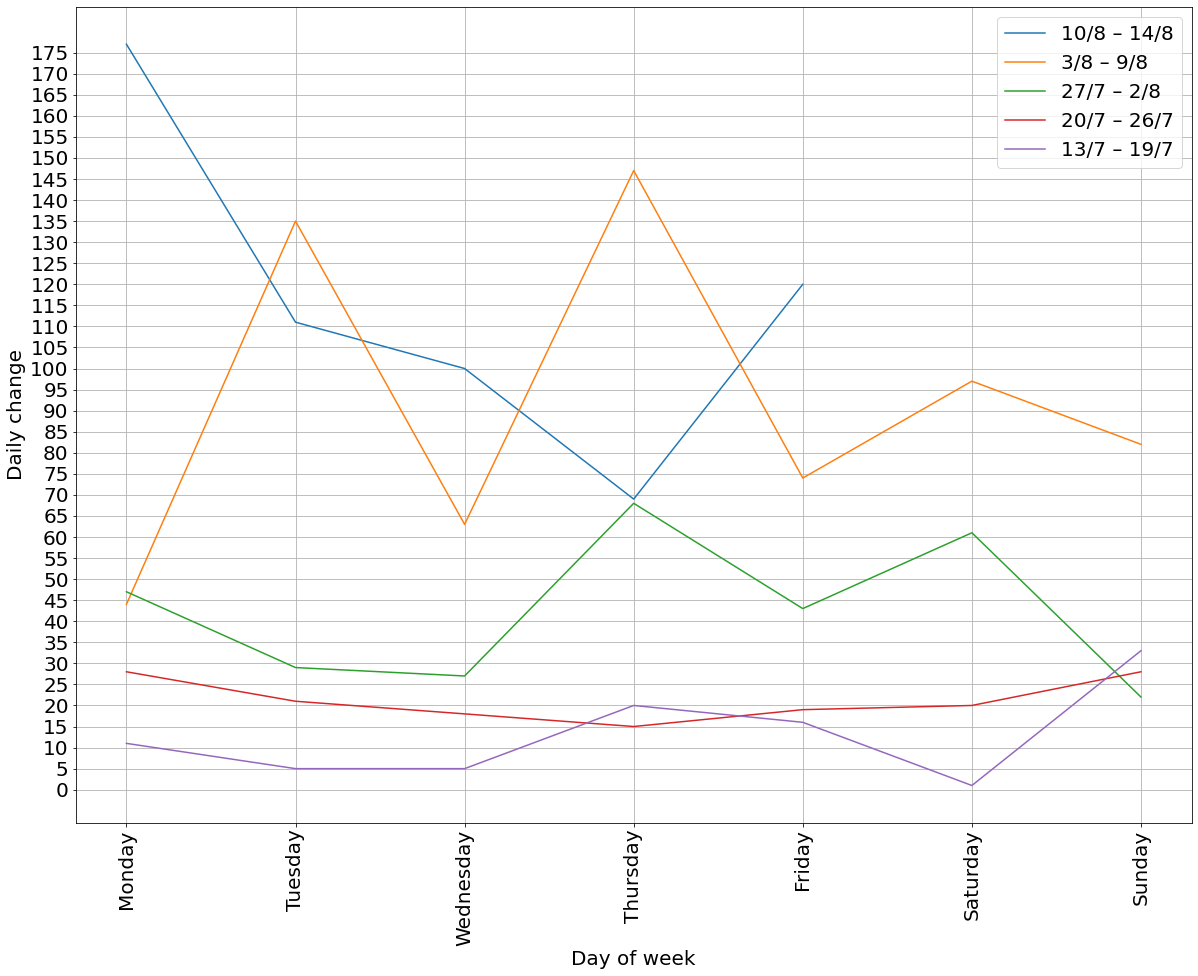

,Date_of_report,Week,Daily_delta,Total_reported
54425,2020-08-08,32,97,3830
54792,2020-08-09,32,82,3912
55159,2020-08-10,33,177,4089
55526,2020-08-11,33,111,4200
55893,2020-08-12,33,100,4300
56260,2020-08-13,33,69,4369
56627,2020-08-14,33,120,4489


In [6]:
plot_daily_delta_for_last_n_weeks(cumuldf, n=5)
plt.show()

cumuldf[["Date_of_report","Week","Daily_delta","Total_reported"]].tail(7)

In [7]:
def plot_weekly_delta_for_last_n_weeks(df:pd.DataFrame, n:int) -> typing.Dict[str,int]:
    """
    Returns a dict containing weekly delta for the last n weeks,
    like: {"Week n": int,"Week n-1": int, ...}
    """

    weekly_delta = {}
    for week in range(0,n):
        if df["Week"].max() < week:
            print(f"Week no. {df['Week'].max() - week} does not exist.")
            continue

        this_week_num = df["Week"].max() - week
        week_delta = df[df["Week"] == this_week_num]["Daily_delta"].sum()

        if this_week_num == 0:
            weekly_delta[f"Week {this_week_num}"] = 0
            continue
        else:
            weekly_delta[f"Week {this_week_num}"] = week_delta
            continue
    return weekly_delta



### Plot week-on-week change in reported cases

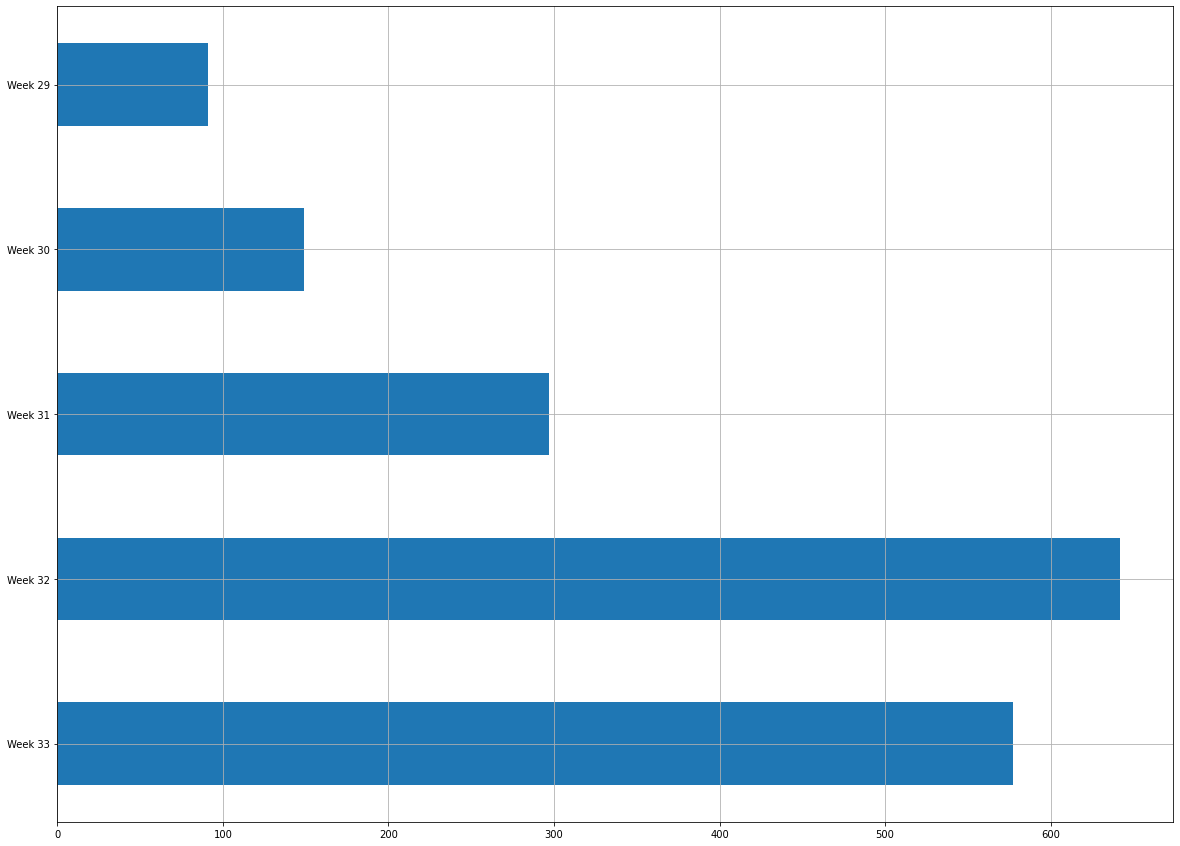

{'Week 29': 91, 'Week 30': 149, 'Week 31': 297, 'Week 32': 642, 'Week 33': 577}


In [8]:
weekly_delta = plot_weekly_delta_for_last_n_weeks(cumuldf, 5)
plt.grid(True)
plt.barh(
    list(weekly_delta.keys()),
    width=np.array(list(weekly_delta.values())),
    height=0.5
)
plt.show()
pprint(weekly_delta)

In [9]:
def weekly_percentage_incr_for_last_n_weeks(df:pd.DataFrame, n:int) -> typing.Dict[str,float]:
    weekly_percent_delta = {}
    for week in range(0,n):
        if df["Week"].max() < week:
            print(
                f"Week no. {df['Week'].max() - week} does not exist."
            )
            continue

        this_week_num = df["Week"].max() - week
        week_delta = df[
            df["Week"] == this_week_num
        ]["Daily_delta"].sum()

        if this_week_num == 0:
            weekly_percent_delta[
                f"Week {this_week_num}"] = 0
            continue
        else:
            last_week_delta = df[
                df["Week"] == (this_week_num-1)
            ]["Daily_delta"].sum()

            weekly_percent_delta[f"Week {this_week_num}"] = \
                ((week_delta-last_week_delta)/last_week_delta)*100

    return weekly_percent_delta

### Plot week-on-week percentage change in reported cases

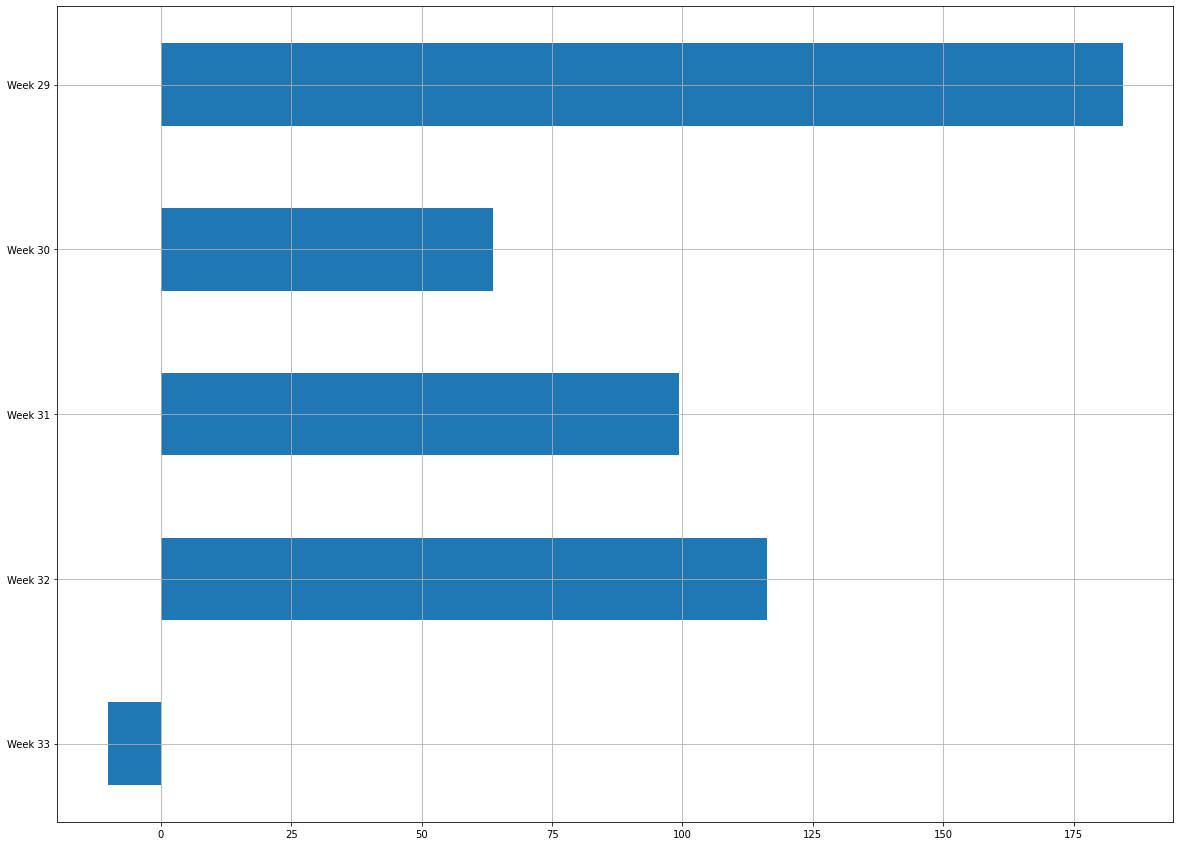

{'Week 29': 184.375,
 'Week 30': 63.73626373626373,
 'Week 31': 99.32885906040269,
 'Week 32': 116.16161616161615,
 'Week 33': -10.12461059190031}


In [10]:
plt.grid(True)
weekly_percent_delta = \
    weekly_percentage_incr_for_last_n_weeks(cumuldf,5)
plt.barh(
    list(weekly_percent_delta.keys()),
    width=np.array(list(weekly_percent_delta.values())),
    height=0.5)
plt.show()
pprint(weekly_percent_delta)

In [11]:
# Helper function to plot last n days cumulative reported cases

def plot_cumul_reported_last_n_days(df:pd.DataFrame,n:int=3, col:str="Total_reported") -> None:
    plot_this = df.tail(n)
    plt.grid(True)
    plt.xticks(rotation="vertical", fontsize=_FONTSIZE)
    plt.yticks(plot_this[col], fontsize=_FONTSIZE)
    plt.plot_date(
        plot_this["Date_of_report"].loc[-n:,],
        plot_this[col],
        xdate=True
    )
    plt.show()
    pprint(df[["Date_of_report", col]].tail(n))

### Cumulative reported cases for the last 7 days

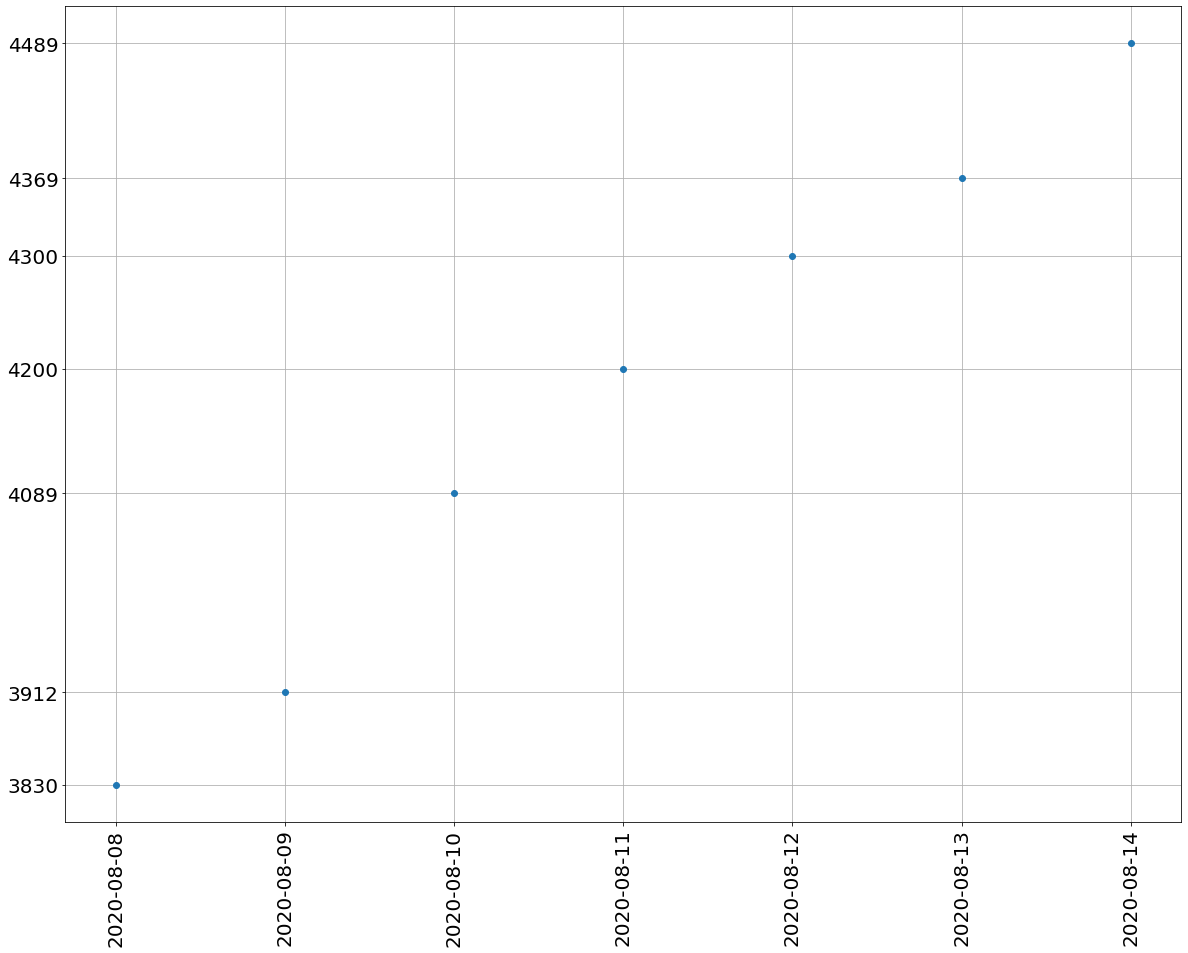

      Date_of_report  Total_reported
54425     2020-08-08            3830
54792     2020-08-09            3912
55159     2020-08-10            4089
55526     2020-08-11            4200
55893     2020-08-12            4300
56260     2020-08-13            4369
56627     2020-08-14            4489


In [12]:
plot_cumul_reported_last_n_days(cumuldf, 7, "Total_reported")

### Cumulative reported cases for the last 14 days

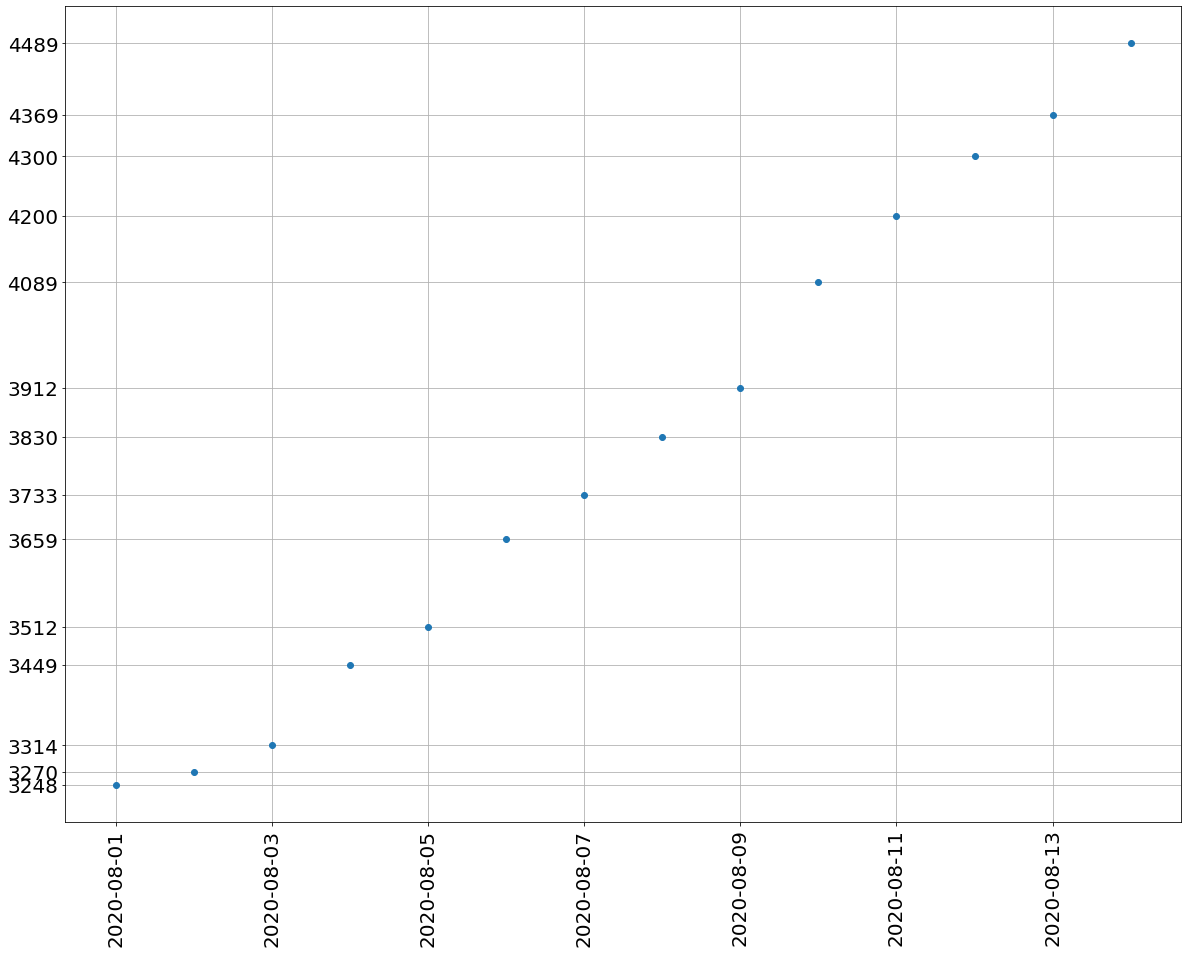

      Date_of_report  Total_reported
51856     2020-08-01            3248
52223     2020-08-02            3270
52590     2020-08-03            3314
52957     2020-08-04            3449
53324     2020-08-05            3512
53691     2020-08-06            3659
54058     2020-08-07            3733
54425     2020-08-08            3830
54792     2020-08-09            3912
55159     2020-08-10            4089
55526     2020-08-11            4200
55893     2020-08-12            4300
56260     2020-08-13            4369
56627     2020-08-14            4489


In [13]:
plot_cumul_reported_last_n_days(cumuldf, 14, "Total_reported")

### Cumulative reported cases for the last 30 days

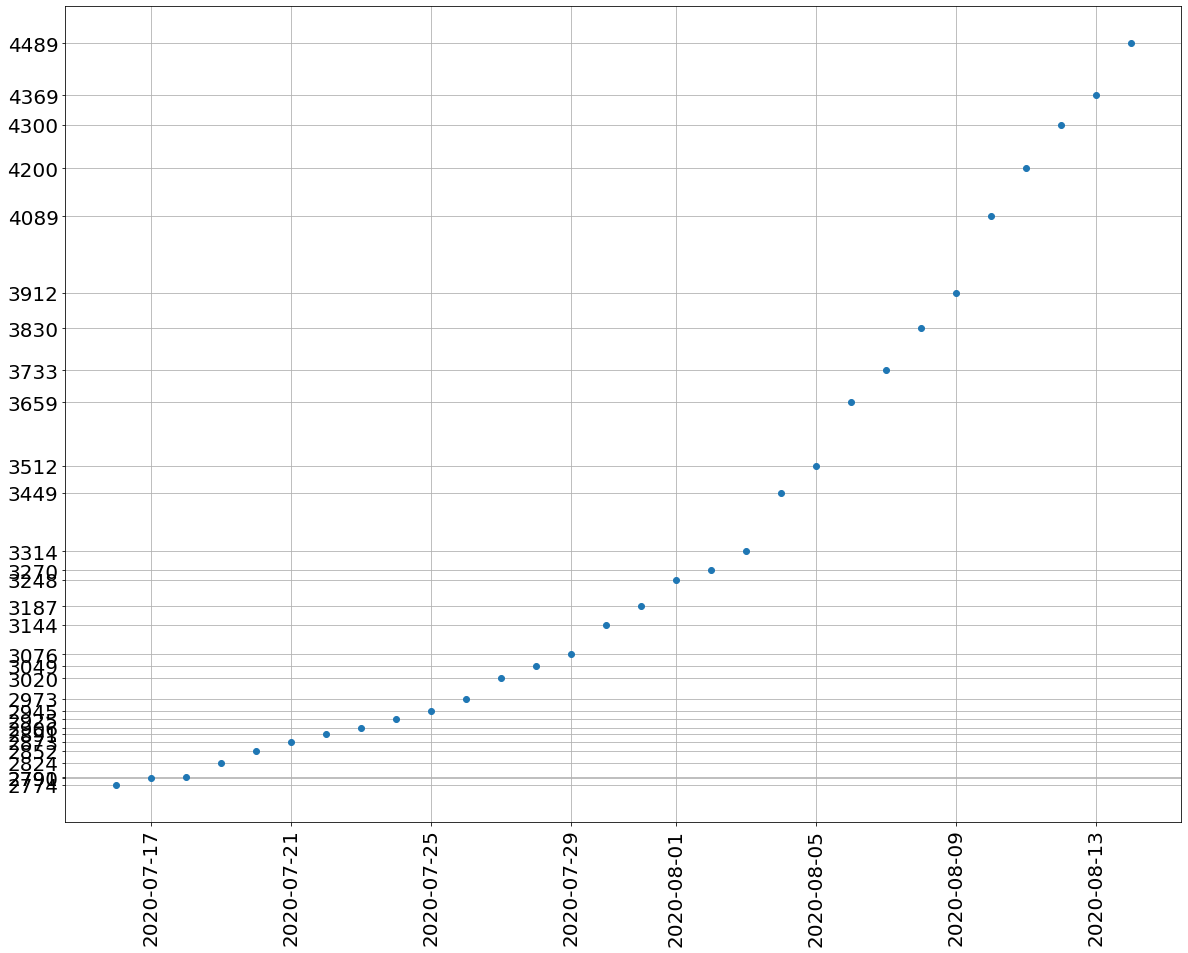

      Date_of_report  Total_reported
45984     2020-07-16            2774
46351     2020-07-17            2790
46718     2020-07-18            2791
47085     2020-07-19            2824
47452     2020-07-20            2852
47819     2020-07-21            2873
48186     2020-07-22            2891
48553     2020-07-23            2906
48920     2020-07-24            2925
49287     2020-07-25            2945
49654     2020-07-26            2973
50021     2020-07-27            3020
50388     2020-07-28            3049
50755     2020-07-29            3076
51122     2020-07-30            3144
51489     2020-07-31            3187
51856     2020-08-01            3248
52223     2020-08-02            3270
52590     2020-08-03            3314
52957     2020-08-04            3449
53324     2020-08-05            3512
53691     2020-08-06            3659
54058     2020-08-07            3733
54425     2020-08-08            3830
54792     2020-08-09            3912
55159     2020-08-10            4089
5

In [14]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Total_reported")

### Hospitalization daily delta for last 30 days

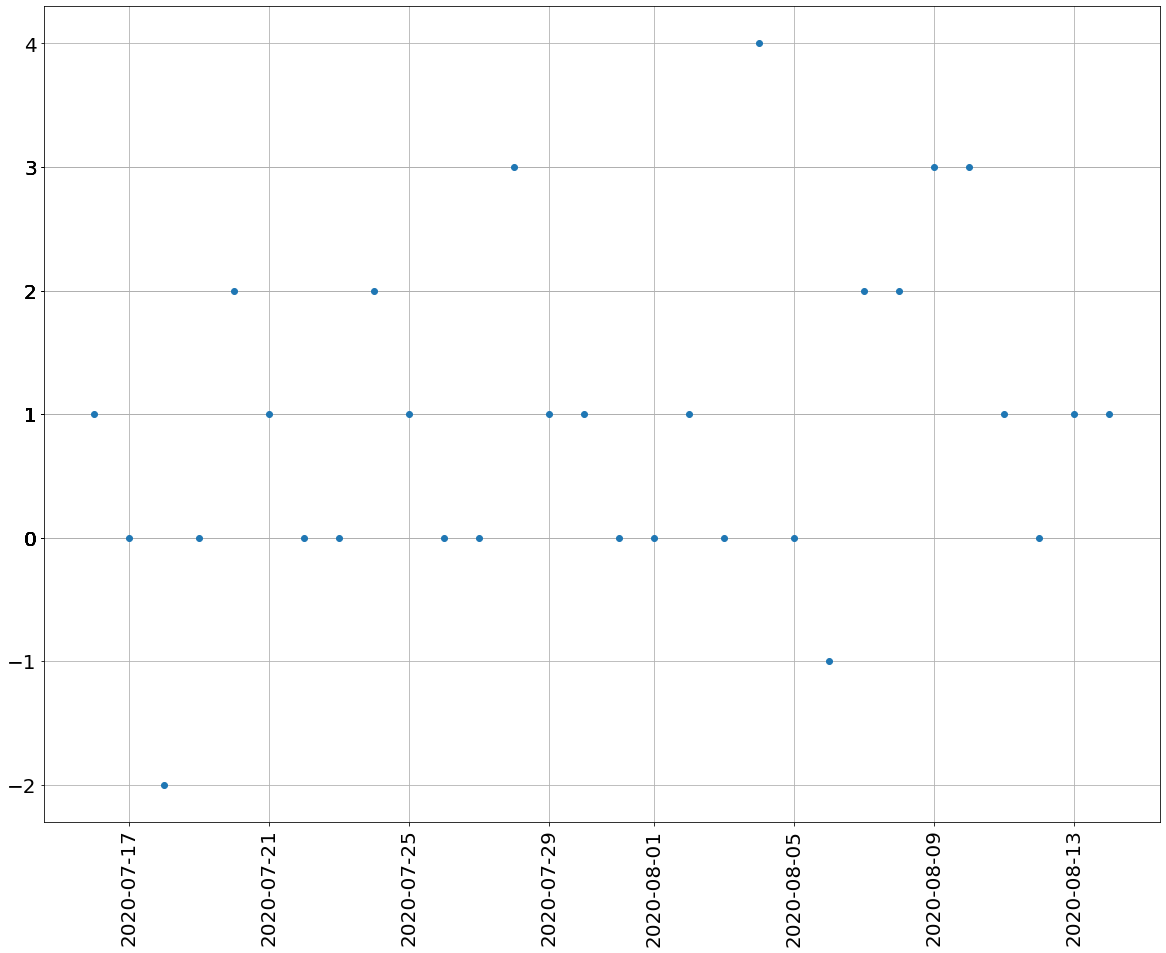

      Date_of_report  Hospital_delta
45984     2020-07-16               1
46351     2020-07-17               0
46718     2020-07-18              -2
47085     2020-07-19               0
47452     2020-07-20               2
47819     2020-07-21               1
48186     2020-07-22               0
48553     2020-07-23               0
48920     2020-07-24               2
49287     2020-07-25               1
49654     2020-07-26               0
50021     2020-07-27               0
50388     2020-07-28               3
50755     2020-07-29               1
51122     2020-07-30               1
51489     2020-07-31               0
51856     2020-08-01               0
52223     2020-08-02               1
52590     2020-08-03               0
52957     2020-08-04               4
53324     2020-08-05               0
53691     2020-08-06              -1
54058     2020-08-07               2
54425     2020-08-08               2
54792     2020-08-09               3
55159     2020-08-10               3
5

In [15]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Hospital_delta")

### Cumulative hospitalizations for last 30 days

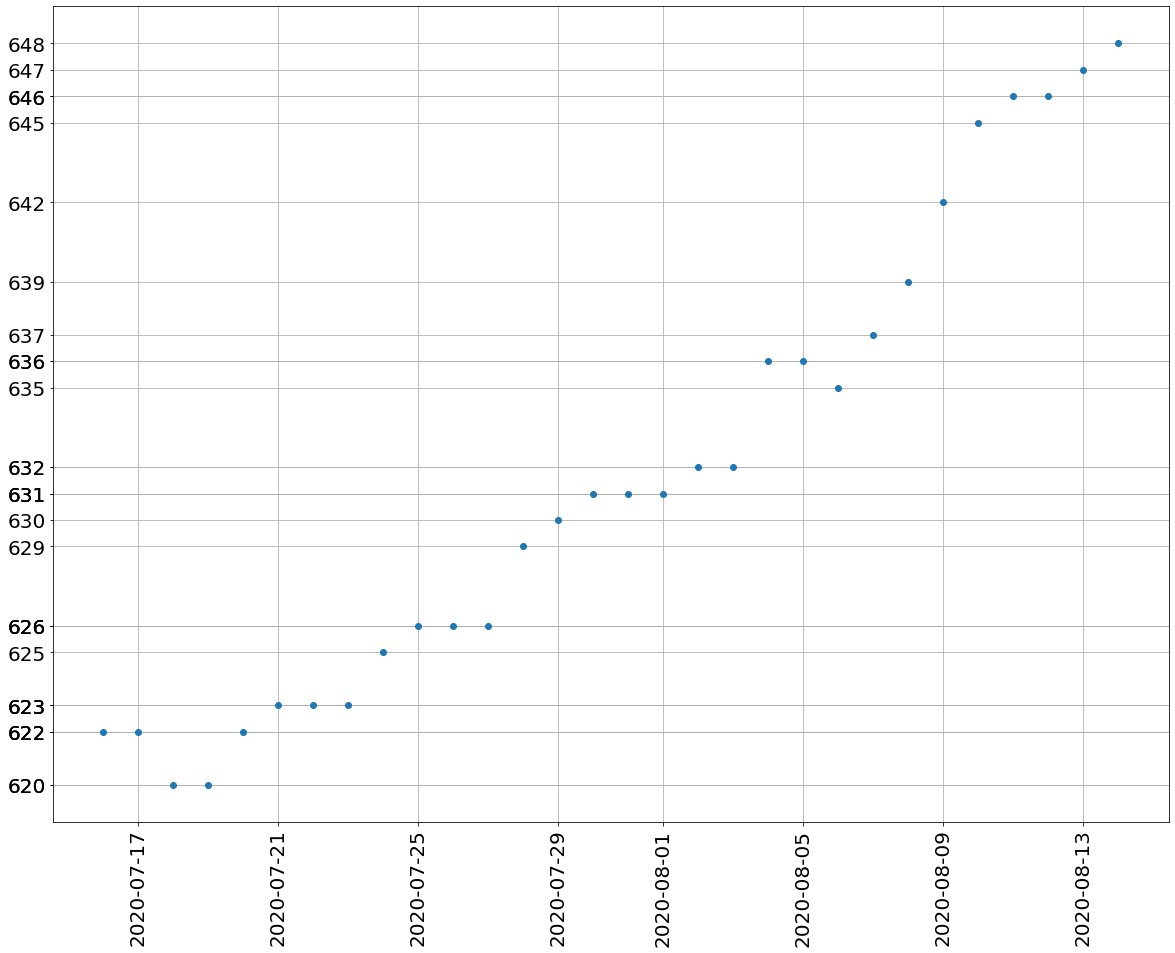

      Date_of_report  Hospital_admission
45984     2020-07-16                 622
46351     2020-07-17                 622
46718     2020-07-18                 620
47085     2020-07-19                 620
47452     2020-07-20                 622
47819     2020-07-21                 623
48186     2020-07-22                 623
48553     2020-07-23                 623
48920     2020-07-24                 625
49287     2020-07-25                 626
49654     2020-07-26                 626
50021     2020-07-27                 626
50388     2020-07-28                 629
50755     2020-07-29                 630
51122     2020-07-30                 631
51489     2020-07-31                 631
51856     2020-08-01                 631
52223     2020-08-02                 632
52590     2020-08-03                 632
52957     2020-08-04                 636
53324     2020-08-05                 636
53691     2020-08-06                 635
54058     2020-08-07                 637
54425     2020-0

In [16]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Hospital_admission")